# 불량품 예측

불량품을 예측하기 위해 다음과 같은 함수화 정리를 진행한다. 혼란을 막기 위해 모든 과정을 함수화 하기로 한다.  
목차는 다음과 같다.

- 1. Load packages & Data
- 2. Function

## 1. Load Packages & Data

In [98]:
### ide packages
import os
from pprint import pprint
import numpy as np
import pandas as pd
import random
import string
from tqdm import tqdm

# sklearn preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    make_scorer,
    roc_curve,
    auc,
    precision_recall_curve,
    recall_score,
)

# models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier, plot_metric
from xgboost import XGBClassifier
import lightgbm as lgb

# plot
import seaborn as sns
import matplotlib.pyplot as plt

# tuning
import optuna

In [82]:
# load data
load_dir = './data/'
train = pd.read_csv(load_dir + "train.csv")
test = pd.read_csv(load_dir + "test.csv")

## 2. Functions

In [36]:
# 평가 스코어 지정하기
f1_scorer = make_scorer(f1_score, pos_label=1, average = 'binary')

# 평가 매트릭 계산 결과 보여주기
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [37]:
# 해당 공정 맞춤형 위치 옮기기
def move_data(data):
    # divide
    dam = data.filter(regex='_Dam')
    fill1 = data.filter(regex='_Fill1')
    fill2 = data.filter(regex='_Fill2')
    autoclave = data.filter(regex='_AutoClave')
    target = data['target']

    # dam
    dam = dam.dropna(axis=1, how='all')
    dam = dam.drop(columns='HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam')
    dam_mask = dam[dam['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].isin(['OK', np.nan])].iloc[:, 24:].shift(-1, axis = 1).values
    dam.loc[dam['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].isin(['OK', np.nan]), dam.columns[24:]] = dam_mask
    dam = dam.drop(columns='WorkMode Collect Result_Dam')

    # fill1
    fill1 = fill1.dropna(axis=1, how='all')
    fill1 = fill1.drop(columns='HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1')
    fill1_mask = fill1[fill1['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].isin(['OK', np.nan])].iloc[:, 14:].shift(-1, axis = 1).values
    fill1.loc[fill1['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].isin(['OK', np.nan]), fill1.columns[14:]] = fill1_mask
    fill1 = fill1.drop(columns='WorkMode Collect Result_Fill1')

    # fill2
    fill2 = fill2.dropna(axis=1, how='all')
    fill2 = fill2.drop(columns='HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2')
    fill2_mask = fill2[fill2['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'].isin(['OK', np.nan])].iloc[:, 24:].shift(-1, axis = 1).values
    fill2.loc[fill2['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'].isin(['OK', np.nan]), fill2.columns[24:]] = fill2_mask
    fill2 = fill2.drop(columns='WorkMode Collect Result_Fill2')

    # CONCAT
    data = pd.concat([dam, fill1, fill2, autoclave, target], axis=1)
    
    return data

In [38]:
# 칼럼 위치 변경
def swap_columns(df, condition, col1, col2):
    # 조건에 해당하는 행 필터링
    filtered_df = df[condition]
    
    # 값 교환
    df.loc[condition, [col1, col2]] = filtered_df[[col1, col2]].copy().iloc[:, ::-1].values

    return df

In [39]:
# Equipment 방향 통일과 잘못된 위치 재조정하기
def change_data(train, test):
    # train
    train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] = train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float)
    train['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'] = train['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float)


    # 이동 전
    X_sum_down_1 = train[train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float) < 500]['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float).mean()
    X_sum_down_2 = train[train['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float) < 500]['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float).mean()
    X_sum_up_1 = train[train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float) > 500]['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float).mean()
    X_sum_up_2 = train[train['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float) > 500]['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float).mean()

    X_sum_down = (X_sum_down_1 - X_sum_down_2) / 2 # stage1에서 빼고, Stage3에서 더하기 <500
    X_sum_up = (X_sum_up_2 - X_sum_up_1) / 2 # stage1에서 더하고, Stage 3에서 빼기

    train.loc[train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] += X_sum_up
    train.loc[train['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'] -= X_sum_up

    train.loc[train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float) < 500, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] -= X_sum_down
    train.loc[train['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float) < 500, 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'] += X_sum_down

    # test
    test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] = test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float)
    test['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'] = test['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float)


    # 이동 전
    test.loc[test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] += X_sum_up
    test.loc[test['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'] -= X_sum_up

    test.loc[test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float) < 500, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] -= X_sum_down
    test.loc[test['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float) < 500, 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'] += X_sum_down

    # train
    Y_sum_dam_1 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'].astype(float) < 500]['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'].astype(float).mean()
    Y_sum_dam_2 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'].astype(float) > 500]['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'].astype(float).mean()

    train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'] = Y_sum_dam_1 + Y_sum_dam_2 - train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam']

    Y_sum_dam_3 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'].astype(float) < 500]['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'].astype(float).mean()
    Y_sum_dam_4 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'].astype(float) > 500]['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'].astype(float).mean()

    train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'] = Y_sum_dam_3 + Y_sum_dam_4 - train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam']

    Y_sum_dam_5 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'].astype(float) < 500]['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'].astype(float).mean()
    Y_sum_dam_6 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'].astype(float) > 500]['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'].astype(float).mean()

    train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'] = Y_sum_dam_5 + Y_sum_dam_6 - train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam']

    Y_sum_fill_1 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'].astype(float) > 500]['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'].astype(float).mean()
    Y_sum_fill_2 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'].astype(float) < 500]['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'].astype(float).mean()

    train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'] = Y_sum_fill_1 + Y_sum_fill_2 - train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1']

    Y_sum_fill_3 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'].astype(float) > 500]['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'].astype(float).mean()
    Y_sum_fill_4 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'].astype(float) < 500]['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'].astype(float).mean()

    train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'] = Y_sum_fill_3 + Y_sum_fill_4 - train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1']

    Y_sum_fill_5 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'].astype(float) > 500]['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'].astype(float).mean()
    Y_sum_fill_6 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'].astype(float) < 500]['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'].astype(float).mean()
    train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'] = Y_sum_fill_5 + Y_sum_fill_6 - train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1']

    # test
    test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'] = Y_sum_dam_1 + Y_sum_dam_2 - test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam']
    test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'] = Y_sum_dam_5 + Y_sum_dam_6 - test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam']
    test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'] = Y_sum_dam_3 + Y_sum_dam_4 - test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam']
    test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'] = Y_sum_fill_1 + Y_sum_fill_2 - test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1']
    test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'] = Y_sum_fill_5 + Y_sum_fill_6 - test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1']
    test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'] = Y_sum_fill_3 + Y_sum_fill_4 - test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1']

    ### Train
    # 조건을 만족하는 행 인덱스를 찾음
    condition = train['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float) >= 200

    # DISCHARGED TIME OF RESIN(Stage1) 
    swap_columns(train, condition, 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam', 'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam')

    # Dispense Volume(Stage1)
    swap_columns(train, condition, 'Dispense Volume(Stage1) Collect Result_Dam', 'Dispense Volume(Stage3) Collect Result_Dam')

    # HEAD NORMAL COORDINATE Y AXIS(Stage1)
    swap_columns(train, condition, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam')

    # HEAD NORMAL COORDINATE Z AXIS(Stage1)
    swap_columns(train, condition, 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam')

    # Stage1 Circle1 Distance Speed Collect
    swap_columns(train, condition, 'Stage1 Circle1 Distance Speed Collect Result_Dam', 'Stage3 Circle1 Distance Speed Collect Result_Dam')
    swap_columns(train, condition, 'Stage1 Circle2 Distance Speed Collect Result_Dam', 'Stage3 Circle2 Distance Speed Collect Result_Dam')
    swap_columns(train, condition, 'Stage1 Circle3 Distance Speed Collect Result_Dam', 'Stage3 Circle3 Distance Speed Collect Result_Dam')
    swap_columns(train, condition, 'Stage1 Circle4 Distance Speed Collect Result_Dam', 'Stage3 Circle4 Distance Speed Collect Result_Dam')

    # Stage1 Line1 Distance Speed Collect
    swap_columns(train, condition, 'Stage1 Line1 Distance Speed Collect Result_Dam', 'Stage3 Line1 Distance Speed Collect Result_Dam')
    swap_columns(train, condition, 'Stage1 Line2 Distance Speed Collect Result_Dam', 'Stage3 Line2 Distance Speed Collect Result_Dam')
    swap_columns(train, condition, 'Stage1 Line3 Distance Speed Collect Result_Dam', 'Stage3 Line3 Distance Speed Collect Result_Dam')
    swap_columns(train, condition, 'Stage1 Line4 Distance Speed Collect Result_Dam', 'Stage3 Line4 Distance Speed Collect Result_Dam')

    # THICKNESS 1
    # swap_columns(train, condition, 'THICKNESS 1 Collect Result_Dam', 'THICKNESS 3 Collect Result_Dam')

    ### 젤 마지막에 와야됨!!!!
    # HEAD NORMAL COORDINATE X AXIS(Stage1)
    swap_columns(train, condition, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam')


    ### Test
    # 조건을 만족하는 행 인덱스를 찾음
    condition = test['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float) >= 200

    # DISCHARGED TIME OF RESIN(Stage1) 
    swap_columns(test, condition, 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam', 'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam')

    # Dispense Volume(Stage1)
    swap_columns(test, condition, 'Dispense Volume(Stage1) Collect Result_Dam', 'Dispense Volume(Stage3) Collect Result_Dam')

    # HEAD NORMAL COORDINATE Y AXIS(Stage1)
    swap_columns(test, condition, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam')

    # HEAD NORMAL COORDINATE Z AXIS(Stage1)
    swap_columns(test, condition, 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam')

    # Stage1 Circle1 Distance Speed Collect
    swap_columns(test, condition, 'Stage1 Circle1 Distance Speed Collect Result_Dam', 'Stage3 Circle1 Distance Speed Collect Result_Dam')
    swap_columns(test, condition, 'Stage1 Circle2 Distance Speed Collect Result_Dam', 'Stage3 Circle2 Distance Speed Collect Result_Dam')
    swap_columns(test, condition, 'Stage1 Circle3 Distance Speed Collect Result_Dam', 'Stage3 Circle3 Distance Speed Collect Result_Dam')
    swap_columns(test, condition, 'Stage1 Circle4 Distance Speed Collect Result_Dam', 'Stage3 Circle4 Distance Speed Collect Result_Dam')

    # Stage1 Line1 Distance Speed Collect
    swap_columns(test, condition, 'Stage1 Line1 Distance Speed Collect Result_Dam', 'Stage3 Line1 Distance Speed Collect Result_Dam')
    swap_columns(test, condition, 'Stage1 Line2 Distance Speed Collect Result_Dam', 'Stage3 Line2 Distance Speed Collect Result_Dam')
    swap_columns(test, condition, 'Stage1 Line3 Distance Speed Collect Result_Dam', 'Stage3 Line3 Distance Speed Collect Result_Dam')
    swap_columns(test, condition, 'Stage1 Line4 Distance Speed Collect Result_Dam', 'Stage3 Line4 Distance Speed Collect Result_Dam')

    # THICKNESS 1
    # swap_columns(train, condition, 'THICKNESS 1 Collect Result_Dam', 'THICKNESS 3 Collect Result_Dam')

    ### 젤 마지막에 와야됨!!!!
    # HEAD NORMAL COORDINATE X AXIS(Stage1)
    swap_columns(test, condition, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam')
    
    ### Train
    # 조건을 만족하는 행 인덱스를 찾음
    condition = train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].astype(float) < 200

    # DISCHARGED TIME OF RESIN(Stage1)
    swap_columns(train, condition, 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1', 'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1')

    # Dispense Volume(Stage1)
    swap_columns(train, condition, 'Dispense Volume(Stage1) Collect Result_Fill1', 'Dispense Volume(Stage3) Collect Result_Fill1')

    # HEAD NORMAL COORDINATE Y AXIS(Stage1)
    swap_columns(train, condition, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1')

    # HEAD NORMAL COORDINATE Z AXIS(Stage1)
    swap_columns(train, condition, 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1')

    # 반드시 마지막으로 와야함!!!!
    # HEAD NORMAL COORDINATE X AXIS(Stage1)
    swap_columns(train, condition, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1')

    ### Test
    condition = test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].astype(float) < 200

    # DISCHARGED TIME OF RESIN(Stage1)
    swap_columns(test, condition, 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1', 'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1')

    # Dispense Volume(Stage1)
    swap_columns(test, condition, 'Dispense Volume(Stage1) Collect Result_Fill1', 'Dispense Volume(Stage3) Collect Result_Fill1')

    # HEAD NORMAL COORDINATE Y AXIS(Stage1)
    swap_columns(test, condition, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1')

    # HEAD NORMAL COORDINATE Z AXIS(Stage1)
    swap_columns(test, condition, 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1')

    # 반드시 마지막으로 와야함!!!!
    # HEAD NORMAL COORDINATE X AXIS(Stage1)
    swap_columns(test, condition, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1')
    
    ### Train
    condition = train['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1'].astype(float) > 500

    # DISCHARGED TIME OF RESIN(Stage1)
    swap_columns(train, condition, 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1', 'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1')

    # Dispense Volume(Stage1)
    swap_columns(train, condition, 'Dispense Volume(Stage1) Collect Result_Fill1', 'Dispense Volume(Stage2) Collect Result_Fill1')

    # HEAD NORMAL COORDINATE Y AXIS(Stage1)
    swap_columns(train, condition, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1')

    # HEAD NORMAL COORDINATE Z AXIS(Stage1)
    swap_columns(train, condition, 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1')

    # 반드시 마지막으로 와야함!!!!
    # HEAD NORMAL COORDINATE X AXIS(Stage1)
    swap_columns(train, condition, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1')

    ### Test
    condition = test['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1'].astype(float) > 500

    # DISCHARGED TIME OF RESIN(Stage1)
    swap_columns(test, condition, 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1', 'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1')

    # Dispense Volume(Stage1)
    swap_columns(test, condition, 'Dispense Volume(Stage1) Collect Result_Fill1', 'Dispense Volume(Stage2) Collect Result_Fill1')

    # HEAD NORMAL COORDINATE Y AXIS(Stage1)
    swap_columns(test, condition, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1')

    # HEAD NORMAL COORDINATE Z AXIS(Stage1)
    swap_columns(test, condition, 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1')

    # 반드시 마지막으로 와야함!!!!
    # HEAD NORMAL COORDINATE X AXIS(Stage1)
    swap_columns(test, condition, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1')

    return train, test

In [40]:
# Dam, Fill1, Fill2에서 지정된 값이 다를 경우 Abnormal 
def inconsistant(data, columnname, iwantthiscolumnsname, is_train = True):
    # 장비 번호가 다르면 불일치
    if is_train:
        cri = [
            df_train[columnname + '_Dam'] != df_train[columnname + '_Fill1'],
            df_train[columnname + '_Dam'] != df_train[columnname + '_Fill2'],
            df_train[columnname + '_Fill1'] != df_train[columnname + '_Fill2'],
            data[iwantthiscolumnsname] == 1
        ]
        
    else:
        cri = [
            df_test[columnname + '_Dam'] != df_test[columnname + '_Fill1'],
            df_test[columnname + '_Dam'] != df_test[columnname + '_Fill2'],
            df_test[columnname + '_Fill1'] != df_test[columnname + '_Fill1'],
            data[iwantthiscolumnsname] == 1
        ]
    con = [1, 1, 1, 1]

    data[iwantthiscolumnsname] = np.select(cri, con, default = 0)

In [41]:
# 변수 세팅
def variable_setting(types, train, test, columns_to_convert, columns_to):
    if types == 'catboost':
        dtype = 'string'  # 원하는 데이터 타입
        for column in columns_to_convert + columns_to:
            train[column] = train[column].astype(dtype)
            test[column] = test[column].astype(dtype)

        dtype = 'category'  # 원하는 데이터 타입
        for column in columns_to_convert + columns_to:
            train[column] = train[column].astype(dtype)
            test[column] = test[column].astype(dtype)
            
    elif types == 'lightgbm':
        dtype = 'float'  # 원하는 데이터 타입
        for column in columns_to_convert + columns_to:
            train[column] = train[column].astype(dtype)
            test[column] = test[column].astype(dtype)

        dtype = 'category'  # 원하는 데이터 타입
        for column in columns_to_convert + columns_to:
            train[column] = train[column].astype(dtype)
            test[column] = test[column].astype(dtype)
            
    elif types == 'xgboost':
        dtype = 'float'  # 원하는 데이터 타입
        for column in columns_to_convert + columns_to:
            train[column] = train[column].astype(dtype)
            test[column] = test[column].astype(dtype)
            
    return train, test

In [42]:
def model_best_threshold(model, X_valid, y_valid):
    # Precision - Recall
    y_pred_proba = model.predict_proba(X_valid)[:, 1]

    precision, recall, thresholds = precision_recall_curve(y_valid, y_pred_proba)
    f1_scores = 2*recall*precision / (recall + precision)
    cat_best_threshold = thresholds[np.argmax(f1_scores)]
    y_pred_custom_threshold = (y_pred_proba >= cat_best_threshold).astype(int)
    
    return thresholds, y_pred_custom_threshold

In [43]:
def xgboost_optuna(train, cat_features_indices):
    X = train.drop(columns=['target'])
    y = train['target']

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1.0, log=True),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
            'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
        }

        model = xgb.XGBClassifier(eval_metric='logloss', **params)

        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=0)

        preds = model.predict(X_valid)
        f1 = f1_score(y_valid, preds)

        return f1

    # Optuna 스터디 생성 및 최적화
    sampler = optuna.samplers.TPESampler(seed=42)
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(objective, n_trials=50)

    # 최적의 하이퍼파라미터 출력
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    return study.best_trial.params, X_train, y_train, X_valid, y_valid, X, y

In [44]:
def lightgbm_optuna(train, cat_features_indices):

    X = train.drop(columns=['target'])
    y = train['target']

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

    def objective(trial):
        lgbm_params = {
            'n_estimators': trial.suggest_int('n_estimators', 400, 1500),
            "max_depth": trial.suggest_int('max_depth', 3, 63),
            "learning_rate": trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True), 
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
            "min_child_weight": trial.suggest_float('min_child_weight', 0.5, 4),
            "min_child_samples": trial.suggest_int('min_child_samples', 5, 100),
            "subsample": trial.suggest_float('subsample', 0.4, 1),
            "subsample_freq": trial.suggest_int('subsample_freq', 0, 5),
            "colsample_bytree": trial.suggest_float('colsample_bytree', 0.2, 1),
            'num_leaves': trial.suggest_int('num_leaves', 2, 64),
        }

        model = LGBMClassifier(**lgbm_params, device='cpu', random_state=42, verbose=-1)

        # 범주형 피처 적용
        model.fit(X_train, y_train, categorical_feature=cat_features_indices)

        # 검증 데이터에서 예측 수행
        y_pred = model.predict(X_valid)

        # F1 점수 계산
        f1 = f1_score(y_valid, y_pred)

        return f1

    # Optuna 스터디 생성 및 최적화
    sampler = optuna.samplers.TPESampler(seed=42)
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(objective, n_trials=50)

    # 최적의 하이퍼파라미터 출력
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    return study.best_trial.params, X_train, y_train, X_valid, y_valid, X, y

In [45]:
def catboost_optuna(train, cat_features_indices):
    
    # train X, y
    X = train.drop(columns=['target'])
    y = train['target']

    # $plit 
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

    # Pooling
    train_pool = Pool(X_train, y_train, cat_features=cat_features_indices)
    valid_pool = Pool(X_valid, y_valid, cat_features=cat_features_indices)
    
    # tuning parameters
    def objective(trial):
        # 하이퍼파라미터를 샘플링
        params = {
            "iterations": trial.suggest_int("iterations", 100, 1000),
            "depth": trial.suggest_int("depth", 4, 10),
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0),
            "border_count": trial.suggest_int("border_count", 32, 255),
            "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0),
            "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
            "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
            "od_wait": trial.suggest_int("od_wait", 10, 50),
            "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
#             "scale_pos_weight": trial.suggest_int('scale_pos_weight', 6, 10),
            "verbose": 0,
            "random_seed": 42
        }

        # CatBoost 모델 학습
        model = CatBoostClassifier(**params)
        model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50, verbose=0)

        # 검증 세트에 대한 예측 및 평가
        preds = model.predict(X_valid)
        f1 = f1_score(y_valid, preds, average='macro')

        return f1

    # Optuna 스터디 생성 및 최적화
    sampler = optuna.samplers.TPESampler(seed=42)
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(objective, n_trials=12)

    # 최적의 하이퍼파라미터 출력
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    return study.best_trial.params, X_train, y_train, X_valid, y_valid, X, y

## 3. Setting

In [46]:
# 기준
columnname = ['Equipment', 'Receip No Collect Result', 'Production Qty Collect Result', 'PalletID Collect Result', ]

In [47]:
# drop oolumns
drop_col = [
    'Stage1 Circle2 Distance Speed Collect Result_Dam',
    'Stage1 Circle3 Distance Speed Collect Result_Dam',
    'Stage1 Circle4 Distance Speed Collect Result_Dam', 
    'Stage2 Circle2 Distance Speed Collect Result_Dam',
    'Stage2 Circle3 Distance Speed Collect Result_Dam',
    'Stage2 Circle4 Distance Speed Collect Result_Dam', 
    'Stage3 Circle2 Distance Speed Collect Result_Dam',
    'Stage3 Circle3 Distance Speed Collect Result_Dam',
    'Stage3 Circle4 Distance Speed Collect Result_Dam',
    
    # Dam, Fill2의 경우 Z값이 서로 같다. -> 그렇다면 Fill1은 높이값에서 흔들린 경우가 있다는 것을 의미한다.
    'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2',
    
    # 의미를 찾을 수 없는 컬럼들 제거
    'Wip Line_Fill1', 
    'Process Desc._Fill1', 
    'Insp. Seq No._Fill1', 
    'Insp Judge Code_Fill1', 
    'Equipment_AutoClave',
    'Process Desc._AutoClave', 
    'Wip Line_AutoClave', 
    'Insp Judge Code_AutoClave',
    'Insp. Seq No._AutoClave',
    '1st Pressure Judge Value_AutoClave', 
    '2nd Pressure Judge Value_AutoClave', 
    '3rd Pressure Judge Value_AutoClave', 
    'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave',
    'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave',
    'GMES_ORIGIN_INSP_JUDGE_CODE Unit Time_AutoClave',
    'Wip Line_Fill2', 
    'Process Desc._Fill2', 
    'Insp. Seq No._Fill2', 
    'Insp Judge Code_Fill2', 
    'Wip Line_Dam', 
    'Process Desc._Dam', 
    'Insp. Seq No._Dam', 
    'Insp Judge Code_Dam',
    'CURE END POSITION X Collect Result_Dam',
    'CURE END POSITION Z Collect Result_Dam',
    'CURE END POSITION Θ Collect Result_Dam',
    'CURE STANDBY POSITION X Collect Result_Dam',
    'CURE STANDBY POSITION Z Collect Result_Dam',
    'CURE STANDBY POSITION Θ Collect Result_Dam',
    
    # Fill2는 레진을 살포하지 않는다. UV만 진행하는 과정이므로 싹 삭제해 준다.          
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2',
    'HEAD Standby Position X Collect Result_Fill2',
    'HEAD Standby Position Y Collect Result_Fill2',
    'HEAD Standby Position Z Collect Result_Fill2',
    'Head Clean Position X Collect Result_Fill2',
    'Head Clean Position Y Collect Result_Fill2',
    'Head Clean Position Z Collect Result_Fill2',
    'Head Purge Position X Collect Result_Fill2',
    'Head Purge Position Y Collect Result_Fill2',
    'Head Purge Position Z Collect Result_Fill2',
    'DISCHARGED SPEED OF RESIN Collect Result_Fill2',
    'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill2',
    'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill2',
    'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill2',
    'Dispense Volume(Stage1) Collect Result_Fill2',
    'Dispense Volume(Stage2) Collect Result_Fill2',
    'Dispense Volume(Stage3) Collect Result_Fill2',
    
    'Stage1 Line1 Distance Speed Collect Result_Dam',
    'Stage1 Line2 Distance Speed Collect Result_Dam',
    'Stage1 Line3 Distance Speed Collect Result_Dam',
    'Stage1 Line4 Distance Speed Collect Result_Dam',
    'Stage2 Line1 Distance Speed Collect Result_Dam',
    'Stage2 Line2 Distance Speed Collect Result_Dam',
    'Stage2 Line3 Distance Speed Collect Result_Dam',
    'Stage2 Line4 Distance Speed Collect Result_Dam',
    'Stage3 Line1 Distance Speed Collect Result_Dam',
    'Stage3 Line2 Distance Speed Collect Result_Dam',
    'Stage3 Line3 Distance Speed Collect Result_Dam',
    'Stage3 Line4 Distance Speed Collect Result_Dam',
    
    # 단일값이 하나인 컬럼들, 의미를 찾고싶다면 주석처리 해야하는 것들
    'CURE START POSITION X Collect Result_Dam', # Equipment에 따라서 정해지며, 하나로 책정됨.
    'CURE START POSITION Z Collect Result_Dam', # START POSITION
    'CURE START POSITION Θ Collect Result_Dam', # Equipment에 따라서 정해지며, 하나로 책정됨.
    'HEAD Standby Position X Collect Result_Dam',
    'HEAD Standby Position Y Collect Result_Dam',
    'HEAD Standby Position Z Collect Result_Dam',
    'Head Clean Position X Collect Result_Dam',
    'Head Clean Position Y Collect Result_Dam', # 흔들림에 따라 Z
    'Head Purge Position X Collect Result_Dam',
    'Head Purge Position Y Collect Result_Dam',
    'Head Zero Position X Collect Result_Dam',
    'HEAD Standby Position X Collect Result_Fill1',
    'HEAD Standby Position Y Collect Result_Fill1',
    'HEAD Standby Position Z Collect Result_Fill1',
    'Head Clean Position X Collect Result_Fill1',
    'Head Clean Position Y Collect Result_Fill1',
    'Head Clean Position Z Collect Result_Fill1',
    'Head Purge Position X Collect Result_Fill1',
    'Head Purge Position Y Collect Result_Fill1',
    'CURE END POSITION X Collect Result_Fill2',
    'CURE END POSITION Θ Collect Result_Fill2',
    'CURE STANDBY POSITION X Collect Result_Fill2',
    'CURE STANDBY POSITION Z Collect Result_Fill2',
    'CURE STANDBY POSITION Θ Collect Result_Fill2',
    'CURE START POSITION X Collect Result_Fill2',
    'CURE START POSITION Θ Collect Result_Fill2',
    
    # AutoClave 의미없어보이는거 제거
    'Chamber Temp. Judge Value_AutoClave',
#     'Chamber Temp. Unit Time_AutoClave',
#     '1st Pressure_AutoClave',
#     '1st Pressure 1st Pressure Unit Time_AutoClave',
#     '2nd Pressure_AutoClave',
#     '2nd Pressure Unit Time_AutoClave',
#     '3rd Pressure_AutoClave',
#     '3rd Pressure Unit Time_AutoClave',
    
    # Model.Suffix, Workorder이 같다.
    'Model.Suffix_Fill1', 'Model.Suffix_Fill2', 'Model.Suffix_AutoClave',
    'Workorder_Fill1', 'Workorder_Fill2', 'Workorder_AutoClave',
    
    # 아무 의미 없는 값
    'Chamber Temp. Judge Value_AutoClave',
    'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave',
    'GMES_ORIGIN_INSP_JUDGE_CODE Unit Time_AutoClave',
    'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave',
    
    # 중복 데이터 없애기
    'PalletID Collect Result_Fill1', 
    'Production Qty Collect Result_Fill1',
    'Receip No Collect Result_Fill1',
    'PalletID Collect Result_Fill2', 
    'Production Qty Collect Result_Fill2',
    'Receip No Collect Result_Fill2',
    'Equipment_Fill1',
    'Equipment_Fill2'
]

## 4. Matched Data

In [48]:
# 위치 옮기기
train_move = move_data(train)
test_move = move_data(test)

/tmp/ipykernel_208/691509256.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.     0.012  0.    ...  0.    -0.019  0.   ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dam.loc[dam['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].isin(['OK', np.nan]), dam.columns[24:]] = dam_mask
/tmp/ipykernel_208/691509256.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[114.612 114.612  85.    ...  85.    114.612  85.   ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  fill2.loc[fill2['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'].isin(['OK', np.nan]), fill2.columns[24:]] = fill2_mask
/tmp/ipykernel_208/691509256.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '

In [49]:
# 위치 변경 및 Equipment2 를 Equipment1 방향으로 변경
df_train, df_test = change_data(train_move, test_move)

### Type Change

In [50]:
# 데이터 타입 변경하기
type_change = ['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam', 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1']

for i in type_change:
    df_train[i] = df_train[i].astype('float64')
    df_test[i] = df_test[i].astype('float64')

### Modified Equipment data type

In [51]:
# Equipment 번호만 가져오기
df_train['Equipment_Dam'] = df_train['Equipment_Dam'].str.slice(15, 16)
df_train['Equipment_Fill1'] = df_train['Equipment_Fill1'].str.slice(17, 18)
df_train['Equipment_Fill2'] = df_train['Equipment_Fill2'].str.slice(17, 18)

df_test['Equipment_Dam'] = df_test['Equipment_Dam'].str.slice(15, 16)
df_test['Equipment_Fill1'] = df_test['Equipment_Fill1'].str.slice(17, 18)
df_test['Equipment_Fill2'] = df_test['Equipment_Fill2'].str.slice(17, 18)

### New Column

In [52]:
# 불일치 변수
df_train['inconsistant'] = 0
df_test['inconsistant'] = 0

# 장착
for i in columnname:
    inconsistant(df_train, i, 'inconsistant', True)
    inconsistant(df_test, i, 'inconsistant', False)

In [53]:
# 시간이 0이하, 900이상인 값은 이상치로 분류
for j in ['Machine Tact time Collect Result_Dam', 'Machine Tact time Collect Result_Fill1', 'Machine Tact time Collect Result_Fill2']:
    cri = [
        df_train[j] <= 0,
        df_train[j] > 900
    ]
    cri2 = [
        df_test[j] <= 0,
        df_test[j] > 900
    ]
    con = [
        1, 1
    ]
    df_train['inconsistant'] = np.select(cri, con, default = df_train['inconsistant'])
    df_test['inconsistant'] = np.select(cri2, con, default = df_test['inconsistant'])

### Speed Line & Circle

In [54]:
# 라인별로 속도가 같아야 정상이다.
df_train['Stage1 Line diffent Distance Speed_Dam'] = ((df_train['Stage1 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage1 Line2 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage1 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage1 Line3 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage1 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage1 Line4 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage1 Line3 Distance Speed Collect Result_Dam'] != df_train['Stage1 Line4 Distance Speed Collect Result_Dam'])).astype(int)
df_train['Stage1 Line Sum Speed_Dam'] = df_train['Stage1 Line1 Distance Speed Collect Result_Dam'] + df_train['Stage1 Line2 Distance Speed Collect Result_Dam'] + df_train['Stage1 Line3 Distance Speed Collect Result_Dam'] + df_train['Stage1 Line4 Distance Speed Collect Result_Dam']

df_train['Stage2 Line diffent Distance Speed_Dam'] = ((df_train['Stage2 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage2 Line2 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage2 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage2 Line3 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage2 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage2 Line4 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage2 Line3 Distance Speed Collect Result_Dam'] != df_train['Stage2 Line4 Distance Speed Collect Result_Dam'])).astype(int)
df_train['Stage2 Line Sum Speed_Dam'] = df_train['Stage2 Line1 Distance Speed Collect Result_Dam'] + df_train['Stage2 Line2 Distance Speed Collect Result_Dam'] + df_train['Stage2 Line3 Distance Speed Collect Result_Dam'] + df_train['Stage2 Line4 Distance Speed Collect Result_Dam']

df_train['Stage3 Line diffent Distance Speed_Dam'] = ((df_train['Stage3 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage3 Line2 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage3 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage3 Line3 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage3 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage3 Line4 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage3 Line3 Distance Speed Collect Result_Dam'] != df_train['Stage3 Line4 Distance Speed Collect Result_Dam'])).astype(int)
df_train['Stage3 Line Sum Speed_Dam'] = df_train['Stage3 Line1 Distance Speed Collect Result_Dam'] + df_train['Stage3 Line2 Distance Speed Collect Result_Dam'] + df_train['Stage3 Line3 Distance Speed Collect Result_Dam'] + df_train['Stage3 Line4 Distance Speed Collect Result_Dam']


In [55]:
# 라인별로 속도가 같아야 정상이다.
df_test['Stage1 Line diffent Distance Speed_Dam'] = ((df_test['Stage1 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage1 Line2 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage1 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage1 Line3 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage1 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage1 Line4 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage1 Line3 Distance Speed Collect Result_Dam'] != df_test['Stage1 Line4 Distance Speed Collect Result_Dam'])).astype(int)
df_test['Stage1 Line Sum Speed_Dam'] = df_test['Stage1 Line1 Distance Speed Collect Result_Dam'] + df_test['Stage1 Line2 Distance Speed Collect Result_Dam'] + df_test['Stage1 Line3 Distance Speed Collect Result_Dam'] + df_test['Stage1 Line4 Distance Speed Collect Result_Dam']

df_test['Stage2 Line diffent Distance Speed_Dam'] = ((df_test['Stage2 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage2 Line2 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage2 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage2 Line3 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage2 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage2 Line4 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage2 Line3 Distance Speed Collect Result_Dam'] != df_test['Stage2 Line4 Distance Speed Collect Result_Dam'])).astype(int)
df_test['Stage2 Line Sum Speed_Dam'] = df_test['Stage2 Line1 Distance Speed Collect Result_Dam'] + df_test['Stage2 Line2 Distance Speed Collect Result_Dam'] + df_test['Stage2 Line3 Distance Speed Collect Result_Dam'] + df_test['Stage2 Line4 Distance Speed Collect Result_Dam']

df_test['Stage3 Line diffent Distance Speed_Dam'] = ((df_test['Stage3 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage3 Line2 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage3 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage3 Line3 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage3 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage3 Line4 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage3 Line3 Distance Speed Collect Result_Dam'] != df_test['Stage3 Line4 Distance Speed Collect Result_Dam'])).astype(int)
df_test['Stage3 Line Sum Speed_Dam'] = df_test['Stage3 Line1 Distance Speed Collect Result_Dam'] + df_test['Stage3 Line2 Distance Speed Collect Result_Dam'] + df_test['Stage3 Line3 Distance Speed Collect Result_Dam'] + df_test['Stage3 Line4 Distance Speed Collect Result_Dam']

### Columns Drop

In [56]:
# 수많은 칼럼 버리기
df_train = df_train.drop(columns = drop_col, axis = 1)
df_test = df_test.drop(columns = drop_col, axis = 1)

### Type 수정

In [57]:
label_encoders = {}
categorical_features = ['Workorder_Dam', 'Model.Suffix_Dam']

# 시드 설정
np.random.seed(42)
for feature in categorical_features:
    le = LabelEncoder()
    df_train[feature] = le.fit_transform(df_train[feature])
    
    # 검증 데이터에 있는 새로운 값에 대해 처리
    unique_values = set(df_test[feature].unique()) - set(le.classes_)
    if unique_values:
        # 새로운 값들을 인코딩할 무작위 숫자 생성
        new_labels = np.random.randint(0, len(le.classes_), size=len(unique_values))
        # 새로운 값들을 인코딩
        le.classes_ = np.append(le.classes_, list(unique_values))
        le.transform(list(unique_values))  # transform을 호출해서 classes_ 업데이트
    
    df_test[feature] = le.transform(df_test[feature])
    label_encoders[feature] = le

### time 보정

In [58]:
# time 보정하기
df_train['rount_1st_time'] = round(df_train['1st Pressure 1st Pressure Unit Time_AutoClave'], -1)
df_train['rount_2nd_time'] = round(df_train['2nd Pressure Unit Time_AutoClave'], -1)
df_train['rount_3rd_time'] = round(df_train['3rd Pressure Unit Time_AutoClave'], -1)
df_train['all_time'] = round(df_train['Chamber Temp. Unit Time_AutoClave'], -1)

df_test['rount_1st_time'] = round(df_test['1st Pressure 1st Pressure Unit Time_AutoClave'], -1)
df_test['rount_2nd_time'] = round(df_test['2nd Pressure Unit Time_AutoClave'], -1)
df_test['rount_3rd_time'] = round(df_test['3rd Pressure Unit Time_AutoClave'], -1)
df_test['all_time'] = round(df_test['Chamber Temp. Unit Time_AutoClave'], -1)

time_col = [
    '1st Pressure 1st Pressure Unit Time_AutoClave',
    '2nd Pressure Unit Time_AutoClave',
    '3rd Pressure Unit Time_AutoClave',
    'Chamber Temp. Unit Time_AutoClave'
]

# 적용
df_train = df_train.drop(columns = time_col, axis = 1)
df_test = df_test.drop(columns = time_col, axis = 1)

### target 0, 1 변환

In [59]:
df_train['target'] = np.where(df_train['target'] == 'Normal', 0, 1)

# 4.5 Dam, Fill, AutoClave 단계마다 적용할 변수 기초 만들기

## 5. 데이터 학습하기

### setting

In [60]:
# 변환 리스트
columns_to_convert = [
    'Receip No Collect Result_Dam',
    'PalletID Collect Result_Dam',
    'Equipment_Dam',
    'Workorder_Dam',
    'Model.Suffix_Dam'
]  

# 변환할 컬럼명 리스트
columns_to = [
    'Head Zero Position Y Collect Result_Dam',
    'Head Zero Position Z Collect Result_Dam',
    'Head Clean Position Z Collect Result_Dam',
    'Head Purge Position Z Collect Result_Dam',
    'Head Purge Position Z Collect Result_Fill1',
    'CURE START POSITION Z Collect Result_Fill2',
    'CURE END POSITION Z Collect Result_Fill2',
    'CURE SPEED Collect Result_Fill2',
    'Stage1 Circle1 Distance Speed Collect Result_Dam',
    'Stage2 Circle1 Distance Speed Collect Result_Dam',
    'Stage3 Circle1 Distance Speed Collect Result_Dam',
    'Stage1 Line diffent Distance Speed_Dam',
    'Stage1 Line Sum Speed_Dam',
    'Stage2 Line diffent Distance Speed_Dam',
    'Stage2 Line Sum Speed_Dam',
    'Stage3 Line diffent Distance Speed_Dam',
    'Stage3 Line Sum Speed_Dam'
]

In [61]:
cat_features_indices = [
    'Receip No Collect Result_Dam',
    'PalletID Collect Result_Dam',
    'Equipment_Dam',
    'Model.Suffix_Dam',
    'Workorder_Dam'] + columns_to

### Catboost

In [29]:
# data
cat_train, cat_test = variable_setting('catboost', df_train, df_test, columns_to_convert, columns_to)

In [ ]:
# optuna tuning
cat_best_params, X_train_cat, y_train_cat, X_valid_cat, y_valid_cat, X_cat, y_cat = catboost_optuna(cat_train, cat_features_indices)

In [ ]:
# print
print(cat_best_params)

In [ ]:
# 최적의 하이퍼파라미터로 모델 재학습
cat_best_params["random_seed"] = 42
cat_best_model = CatBoostClassifier(**cat_best_params)
cat_best_model.fit(X_train_cat, y_train_cat, cat_features=cat_features_indices)

In [ ]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(cat_best_model.feature_importances_, index=list(X_train_cat.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [ ]:
# valid 확인하기
pred = cat_best_model.predict(X_valid_cat)
get_clf_eval(y_valid_cat, pred)

In [ ]:
# 최적의 threshold와 그 때의 예측 값 가져오기
threshold_cat, y_pred_custom_threshold_cat = model_best_threshold(cat_best_model, X_valid_cat, y_valid_cat)
get_clf_eval(y_valid_cat, y_pred_custom_threshold_cat)

In [ ]:
# tmp
proba1 = cat_best_model.predict_proba(X_cat)[:, 1]

### LGBM

In [110]:
# data
lgbm_train, lgbm_test = variable_setting('lightgbm', df_train, df_test, columns_to_convert, columns_to)

In [63]:
# optuna tuning
lgbm_best_params, X_train_lgbm, y_train_lgbm, X_valid_lgbm, y_valid_lgbm, X_lgbm, y_lgbm = lightgbm_optuna(lgbm_train, cat_features_indices)

[I 2024-08-18 16:25:06,365] A new study created in memory with name: no-name-0e02e847-7850-4b00-a4a9-2c96547295af
[I 2024-08-18 16:25:08,968] Trial 0 finished with value: 0.06751054852320675 and parameters: {'n_estimators': 812, 'max_depth': 60, 'learning_rate': 0.0029106359131330704, 'reg_alpha': 0.24810409748678125, 'reg_lambda': 0.004207988669606638, 'min_child_weight': 1.0459808211767092, 'min_child_samples': 10, 'subsample': 0.9197056874649611, 'subsample_freq': 3, 'colsample_bytree': 0.7664580622368364, 'num_leaves': 3}. Best is trial 0 with value: 0.06751054852320675.
[I 2024-08-18 16:25:12,184] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 1467, 'max_depth': 53, 'learning_rate': 0.00026587543983272726, 'reg_alpha': 0.005337032762603957, 'reg_lambda': 0.00541524411940254, 'min_child_weight': 1.564847850358382, 'min_child_samples': 55, 'subsample': 0.6591670111852694, 'subsample_freq': 1, 'colsample_bytree': 0.6894823157779035, 'num_leaves': 10}. Best is trial

Best trial:
  Value: 0.14056224899598393
  Params: 
    n_estimators: 1325
    max_depth: 43
    learning_rate: 0.009871149613069051
    reg_alpha: 0.028967847134875147
    reg_lambda: 0.0010048404716309263
    min_child_weight: 1.0585590904879165
    min_child_samples: 78
    subsample: 0.5695496693451576
    subsample_freq: 5
    colsample_bytree: 0.6246339245050061
    num_leaves: 61


In [64]:
# print
print(lgbm_best_params)

{'n_estimators': 1325, 'max_depth': 43, 'learning_rate': 0.009871149613069051, 'reg_alpha': 0.028967847134875147, 'reg_lambda': 0.0010048404716309263, 'min_child_weight': 1.0585590904879165, 'min_child_samples': 78, 'subsample': 0.5695496693451576, 'subsample_freq': 5, 'colsample_bytree': 0.6246339245050061, 'num_leaves': 61}


In [66]:
lgbm_best_params["random_state"] = 42  # LightGBM에서는 random_state를 사용합니다.
lgbm_best_model = LGBMClassifier(**lgbm_best_params)
lgbm_best_model.fit(X_train_lgbm, y_train_lgbm, categorical_feature=cat_features_indices)

LGBMClassifier(colsample_bytree=0.6246339245050061,
               learning_rate=0.009871149613069051, max_depth=43,
               min_child_samples=78, min_child_weight=1.0585590904879165,
               n_estimators=1325, num_leaves=61, random_state=42,
               reg_alpha=0.028967847134875147, reg_lambda=0.0010048404716309263,
               subsample=0.5695496693451576, subsample_freq=5)

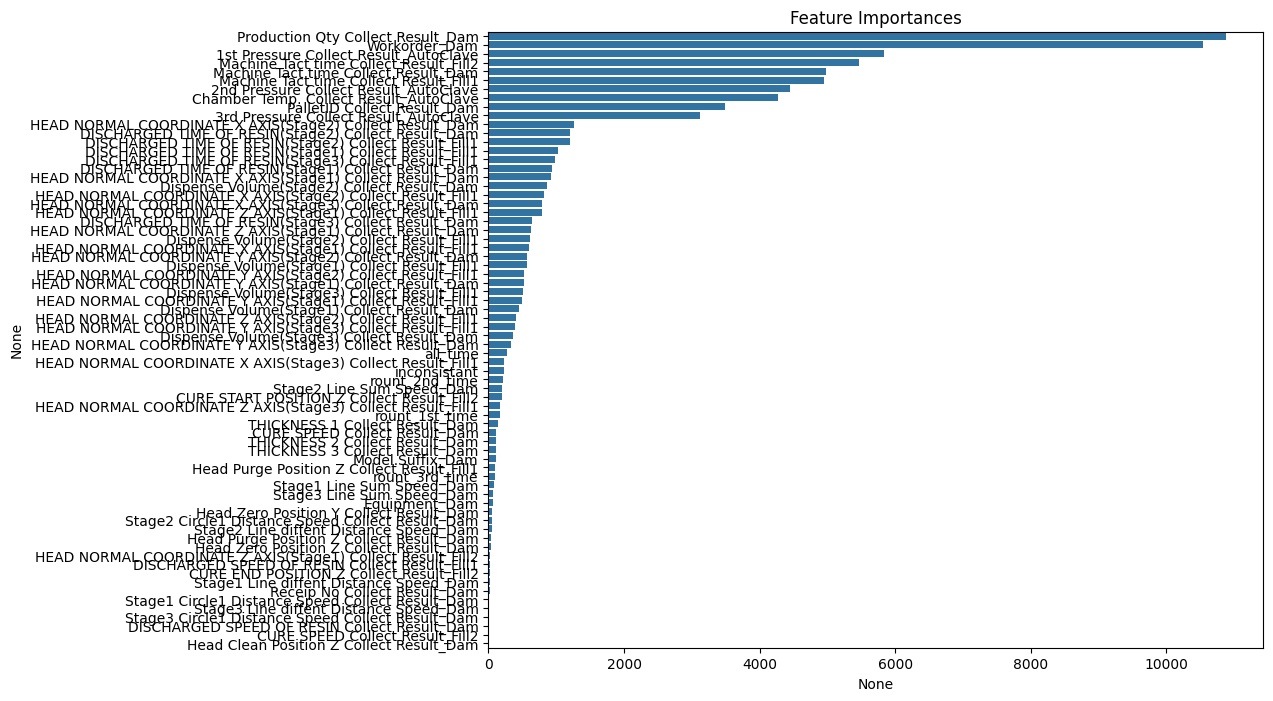

In [67]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(lgbm_best_model.feature_importances_, index=list(X_train_lgbm.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [68]:
pred = lgbm_best_model.predict(X_valid_lgbm)
get_clf_eval(y_valid_lgbm, pred)

오차행렬:
 [[  35  423]
 [   5 7639]]

정확도: 0.9472
정밀도: 0.8750
재현율: 0.0764
F1: 0.1406


In [70]:
# 최적의 threshold와 그 때의 예측 값 가져오기
threshold_lgbm, y_pred_custom_threshold_lgbm = model_best_threshold(lgbm_best_model, X_valid_lgbm, y_valid_lgbm)
get_clf_eval(y_valid_lgbm, y_pred_custom_threshold_lgbm)

오차행렬:
 [[  76  382]
 [ 121 7523]]

정확도: 0.9379
정밀도: 0.3858
재현율: 0.1659
F1: 0.2321


In [71]:
proba2 = lgbm_best_model.predict_proba(X_lgbm)[:, 1]

### XGB

In [73]:
# data
xgb_train, xgb_test = variable_setting('xgboost', df_train, df_test, columns_to_convert, columns_to)

In [74]:
# optuna tuning
xgb_best_params, X_train_xgb, y_train_xgb, X_valid_xgb, y_valid_xgb, X_xgb, y_xgb = xgboost_optuna(xgb_train, cat_features_indices)

[I 2024-08-18 16:33:05,304] A new study created in memory with name: no-name-171f93b3-7f6d-42bd-857c-b4bdf02cf137
[I 2024-08-18 16:33:08,590] Trial 0 finished with value: 0.13916500994035785 and parameters: {'n_estimators': 437, 'max_depth': 10, 'learning_rate': 0.15702970884055384, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'lambda': 0.0017073967431528124, 'alpha': 2.9154431891537547}. Best is trial 0 with value: 0.13916500994035785.
[I 2024-08-18 16:33:12,697] Trial 1 finished with value: 0.11134020618556702 and parameters: {'n_estimators': 641, 'max_depth': 8, 'learning_rate': 0.00115279871282324, 'subsample': 0.9849549260809971, 'colsample_bytree': 0.9162213204002109, 'gamma': 1.0616955533913808, 'lambda': 0.005337032762603957, 'alpha': 0.00541524411940254}. Best is trial 0 with value: 0.13916500994035785.
[I 2024-08-18 16:33:15,065] Trial 2 finished with value: 0.12678936605316973 and parameters: {'n_estimators': 374, 'max

Best trial:
  Value: 0.1875
  Params: 
    n_estimators: 701
    max_depth: 10
    learning_rate: 0.9923011126856865
    subsample: 0.7660999617341604
    colsample_bytree: 0.7591416621317699
    gamma: 0.6327155841428214
    lambda: 0.9526097633865376
    alpha: 0.0011969062590495645


In [75]:
# print
print(xgb_best_params)

{'n_estimators': 701, 'max_depth': 10, 'learning_rate': 0.9923011126856865, 'subsample': 0.7660999617341604, 'colsample_bytree': 0.7591416621317699, 'gamma': 0.6327155841428214, 'lambda': 0.9526097633865376, 'alpha': 0.0011969062590495645}


In [76]:
# 최적의 하이퍼파라미터로 모델 재학습
xgb_best_params["random_state"] = 42
xgb_best_model = xgb.XGBClassifier(**xgb_best_params)
xgb_best_model.fit(X_train_xgb, y_train_xgb)

XGBClassifier(alpha=0.0011969062590495645, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7591416621317699, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.6327155841428214,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.9526097633865376,
              learning_rate=0.9923011126856865, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=701, n_jobs=None, ...)

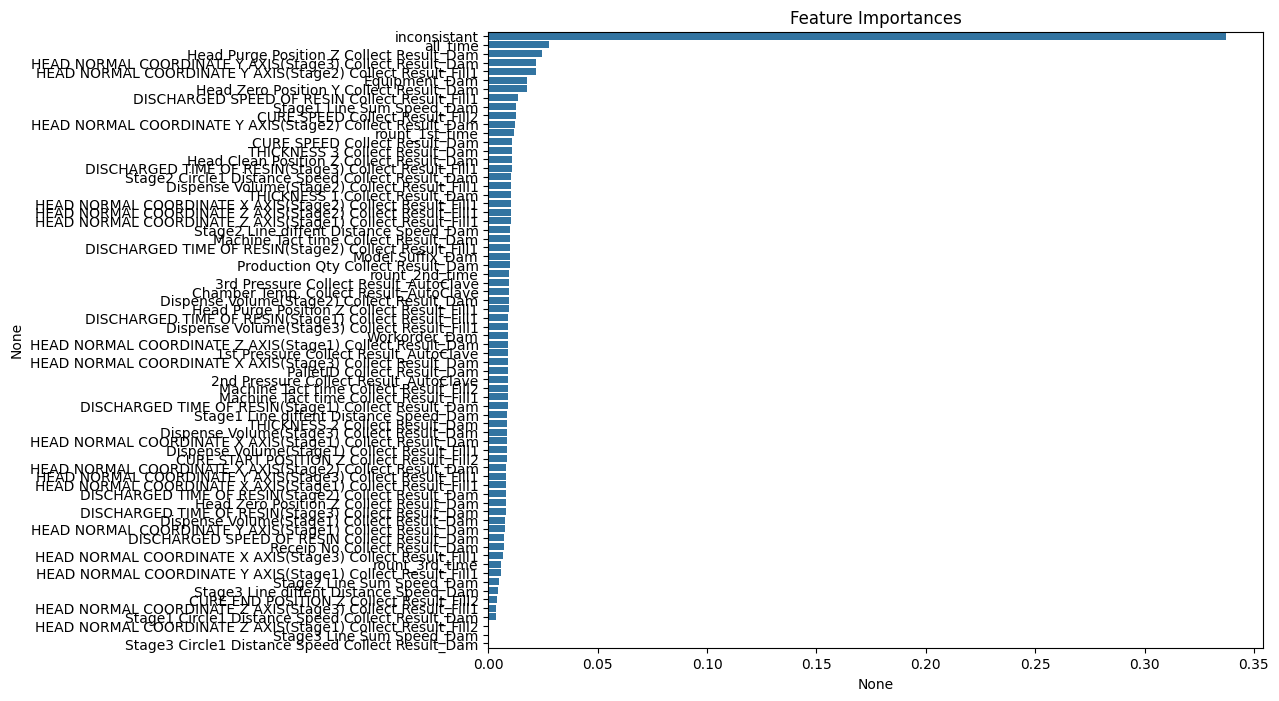

In [77]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(xgb_best_model.feature_importances_, index=list(X_train_xgb.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [78]:
pred = xgb_best_model.predict(X_valid_xgb)
get_clf_eval(y_valid_xgb, pred)

오차행렬:
 [[  56  402]
 [ 197 7447]]

정확도: 0.9261
정밀도: 0.2213
재현율: 0.1223
F1: 0.1575


In [79]:
# 최적의 threshold와 그 때의 예측 값 가져오기
threshold_xgb, y_pred_custom_threshold_xgb = model_best_threshold(xgb_best_model, X_valid_xgb, y_valid_xgb)
get_clf_eval(y_valid_xgb, y_pred_custom_threshold_xgb)

오차행렬:
 [[  72  386]
 [ 264 7380]]

정확도: 0.9198
정밀도: 0.2143
재현율: 0.1572
F1: 0.1814


In [80]:
proba3 = xgb_best_model.predict_proba(X_xgb)[:, 1]

## 6. Inference

In [113]:
set_id = pd.read_csv(load_dir + 'test.csv')
cat_test = pd.concat([cat_test, set_id['Set ID']], axis = 1)
xgb_test = pd.concat([xgb_test, set_id['Set ID']], axis = 1)
lgbm_test = pd.concat([lgbm_test, set_id['Set ID']], axis = 1)

### Catboost

In [86]:
# test pool# test pool
cat_test_pool = Pool(data=cat_test.drop(columns='Set ID'), cat_features=cat_features_indices)

In [ ]:
# 최적의 하이퍼파라미터로 모델 재학습
cat_best_params["random_seed"] = 42
cat_best_model = CatBoostClassifier(**cat_best_params)
cat_best_model.fit(X_cat, y_cat, cat_features=cat_features_indices)

In [ ]:
# pred
cat_pred = cat_best_model.predict(cat_test.drop(columns='Set ID'))

### LGBM

In [95]:
# 최적의 하이퍼파라미터로 모델 재학습
lgbm_best_params["random_seed"] = 42
lgbm_best_model = LGBMClassifier(**lgbm_best_params)
lgbm_best_model.fit(X_lgbm, y_lgbm, categorical_feature=cat_features_indices)

LGBMClassifier(colsample_bytree=0.6246339245050061,
               learning_rate=0.009871149613069051, max_depth=43,
               min_child_samples=78, min_child_weight=1.0585590904879165,
               n_estimators=1325, num_leaves=61, random_seed=42,
               random_state=42, reg_alpha=0.028967847134875147,
               reg_lambda=0.0010048404716309263, subsample=0.5695496693451576,
               subsample_freq=5)

In [114]:
# pred
lgbm_pred = lgbm_best_model.predict(lgbm_test.drop(columns=['Set ID', 'target']))

### XGB

In [99]:
# 최적의 하이퍼파라미터로 모델 재학습
xgb_best_params["random_seed"] = 42
xgb_best_model = XGBClassifier(**xgb_best_params)
xgb_best_model.fit(X_xgb, y_xgb)

/home/elicer/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [16:42:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "random_seed" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(alpha=0.0011969062590495645, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7591416621317699, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.6327155841428214,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.9526097633865376,
              learning_rate=0.9923011126856865, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=701, n_jobs=None, ...)

In [102]:
# pred
xgb_pred = xgb_best_model.predict(xgb_test.drop(columns=['Set ID', 'target']))

## 7. Submission

In [118]:
# 변수 재변환이 필요
p = np.where(xgb_pred == 0, 'Normal', 'AbNormal')

In [119]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["target"] = xgb_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

# 꼭 df_sub['target'] 확인하고 제출하시오